In [18]:
# Preparing dataset

!curl -L -o ./archive.zip https://www.kaggle.com/api/v1/datasets/download/saurabhshahane/ecommerce-text-classification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8043k  100 8043k    0     0  14.6M      0 --:--:-- --:--:-- --:--:--  158M


In [19]:
import zipfile

with zipfile.ZipFile("./archive.zip") as f:
    f.extractall("./data")

In [20]:
import pandas as pd

data = pd.read_csv("./data/ecommerceDataset.csv", header=None)
data.columns = ["category", "description"]

In [21]:
categories = data["category"].unique()

In [22]:
# Removing N/A data
data[data["description"].isna()]

,category,description
39330,Clothing & Accessories,NaN


In [23]:
data = data.dropna(axis=0)
data[data["description"].isna()]

,category,description


In [24]:
categories = data["category"].astype("category")
data.drop("category", axis="columns", inplace=True)
data["category"] = categories

data["codes"] = data.category.cat.codes

In [25]:
TRAIN_SIZE = 2000
TEST_SIZE = 1000

train_data, test_data = data.sample(frac=TRAIN_SIZE / len(data)), data.sample(frac=TEST_SIZE / len(data))

print(len(train_data), len(test_data))

2000 1000


In [26]:
train_data

,description,category,codes
45980,"Dot & Key Underarm Colour Correction Serum, un...",Electronics,2
24105,Emotion and Relationships Review Relationships...,Books,0
49320,Mobimint 2 A Android Micro USB Cable with 2.4 ...,Electronics,2
7869,Glorious Plastic Sturdy Multipurpose Cloth Cli...,Household,3
29562,International Mathematics Olympiad Work Book (...,Books,0
...,...,...,...
14676,Dream Care Waterproof Dishwasher Cover For Bos...,Household,3
45020,ROSENICE Wireless WiFi Display TV Dongle Recei...,Electronics,2
38619,Segolike Colorful Cotton Ethnic Eyeglass Cord ...,Clothing & Accessories,1
4739,Seven Horses 24 Inch Round Frameless Bevelled ...,Household,3


In [27]:
# Creating labels
import keras

In [28]:
y_train = keras.utils.to_categorical(train_data["codes"])
print(y_train.shape, y_train[0])

(2000, 4) [0. 0. 1. 0.]


In [29]:
# Creating features
import spacy
nlp = spacy.load("en_core_web_sm")

max_desc_len = 100

features_text = []
vocab = set()

for desc in train_data["description"]:
    tokens = [token.text.lower() for token in nlp(desc) if not token.is_space]
    tokens = tokens[:max_desc_len]
    vocab.update(tokens)
    features_text.append(tokens)

vocab.add("<PAD>")
print(len(features_text), len(vocab))

2000 15621


In [30]:
# Create embeddings

word_to_idx = {word:idx for (idx, word) in enumerate(vocab)}
idx_to_word = {idx: word for (word, idx) in word_to_idx.items()}

embedding_size = 128

embeddings = keras.layers.Embedding(len(vocab), embedding_size, mask_zero=True)


In [31]:
from keras.preprocessing.sequence import pad_sequences

sequences = [[word_to_idx[token] for token in tokens] for tokens in features_text]

x_train = pad_sequences(sequences, maxlen=max_desc_len, padding='post', value=word_to_idx["<PAD>"])
print(x_train.shape)

(2000, 100)


In [40]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(len(vocab), embedding_size, mask_zero=True))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation="softmax"))

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
optim = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=True, validation_split=0.2)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.3466 - loss: 1.3653 - val_accuracy: 0.4100 - val_loss: 1.2990
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.3983 - loss: 1.2220 - val_accuracy: 0.6200 - val_loss: 0.9827
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.5885 - loss: 0.9553 - val_accuracy: 0.6175 - val_loss: 0.9225
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6104 - loss: 0.8911 - val_accuracy: 0.6225 - val_loss: 0.8964
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.6445 - loss: 0.8107 - val_accuracy: 0.6475 - val_loss: 0.8498
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.7112 - loss: 0.7189 - val_accuracy: 0.7000 - val_loss: 0.8090
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7439 - loss: 0.6690 - val_accuracy: 0.6300 - val_loss: 0.9263
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7132 - loss: 0.7475 - val_accuracy: 0.6575 -

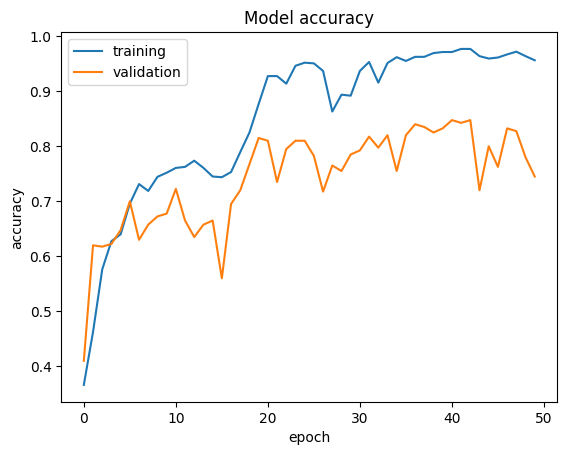

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["training", "validation"], loc="best")
plt.show()